# Image Classification using Tomato Leaves Dataset

**Dataset**: [tomato-leaves-dataset](https://huggingface.co/datasets/artup1/tomato-leaves-dataset)

This notebook demonstrates a complete image classification pipeline to achieve **95%+ accuracy** on tomato leaf disease classification.

## Dataset Overview
- **Classes**: 8 (various tomato diseases + healthy)
- **Split**: Train (80%), Validation (10%), Test (10%)
- **Augmentation**: Aggressive augmentation to create 10,000+ training samples

## Objectives
1. ✓ Dataset with 10,000+ effective samples (via augmentation)
2. ✓ Sequential CNN model with Conv2D and Pooling layers
3. ✓ Custom callback to stop at 95% accuracy
4. ✓ Training visualization (accuracy & loss plots)
5. ✓ Model deployment in 3 formats (SavedModel, TF-Lite, TFJS)
6. ✓ Inference demonstration

## 1. Import Libraries

In [2]:
import os
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import splitfolders
import zipfile
from huggingface_hub import hf_hub_download

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2026-02-04 12:37:55.591262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-04 12:37:55.599541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-04 12:37:56.176014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 12:38:03.043948: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

TensorFlow version: 2.20.0
GPU Available: []


E0000 00:00:1770183491.428752   43355 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770183491.438000   43355 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. Data loading from Huggingface Dataset

In [3]:
# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running in local environment")

# Set base directory based on environment
if IN_COLAB:
    # In Colab, use /content directory
    WORK_DIR = '/content'
else:
    # In local, use current directory
    WORK_DIR = '.'

# Update BASE_DIR to use WORK_DIR
BASE_DIR = os.path.join(WORK_DIR, 'dataset_final')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

if not os.path.exists(BASE_DIR):
    print(f"\nDataset not found at: {BASE_DIR}")
    print("Downloading dataset from Hugging Face...")
    print("This may take a few minutes (dataset size: ~500MB)...\n")
    
    try:
        zip_path = hf_hub_download(
            repo_id="Jotadebeese/rubbish_augmented",
            filename="rubbish_dataset_augmented.zip",
            repo_type="dataset"
        )
        
        print(f"Download complete: {zip_path}")
        print("Extracting dataset...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            zip_ref.extractall(WORK_DIR)
            print(f"Extracted {len(file_list)} files")
    
        extracted_dirs = [d for d in os.listdir(WORK_DIR) if os.path.isdir(os.path.join(WORK_DIR, d))]
        
        possible_dataset_dirs = ['dataset', 'rubbish_dataset_augmented', 'data']
        for dir_name in extracted_dirs:
            if any(name in dir_name.lower() for name in possible_dataset_dirs):
                potential_base = os.path.join(WORK_DIR, dir_name)

                # Check if it has train/val/test subdirectories
                if all(os.path.exists(os.path.join(potential_base, split)) 
                       for split in ['train', 'validation', 'test']):
                    BASE_DIR = potential_base
                    TRAIN_DIR = os.path.join(BASE_DIR, 'train')
                    VAL_DIR = os.path.join(BASE_DIR, 'validation')
                    TEST_DIR = os.path.join(BASE_DIR, 'test')
                    break
        
        print(f"\nDataset downloaded and extracted to: {BASE_DIR}")
        
        # Clean up corrupted files
        print("\nCleaning up corrupted files...")
        corrupted_count = 0
        
        for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
            if os.path.exists(split_dir):
                for class_name in os.listdir(split_dir):
                    class_path = os.path.join(split_dir, class_name)
                    if os.path.isdir(class_path):
                        for filename in os.listdir(class_path):
                            file_path = os.path.join(class_path, filename)
                            try:
                                # Try to open as image
                                from PIL import Image
                                with Image.open(file_path) as img:
                                    img.verify()
                            except Exception:
                                # If it fails, it's corrupted - delete it
                                os.remove(file_path)
                                corrupted_count += 1
        
        if corrupted_count > 0:
            print(f"Removed {corrupted_count} corrupted files")
        else:
            print("No corrupted files found")
            
    except Exception as e:
        print(f"\n Error downloading dataset: {e}")
        print("\nPlease manually download the dataset from:")
        print("https://huggingface.co/datasets/Jotadebeese/rubbish_augmented")
        raise
else:
    print(f"\n Dataset already exists at: {BASE_DIR}")
    print("\nSkipping download...")

input_folder = 'rubbish_dataset_augmented'
output_folder = 'dataset_final'

splitfolders.ratio(input_folder, output=output_folder, 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None, move=False)

print("Proses split selesai! Cek folder:", output_folder)

# Verify dataset structure
print("\nDATASET VERIFICATION")
print(f"Base directory: {BASE_DIR}")
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(VAL_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

if all(os.path.exists(d) for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    print(f"\n✓ Dataset structure verified!")
    print(f"Train classes: {len(os.listdir(TRAIN_DIR))}")
    print(f"Validation classes: {len(os.listdir(VAL_DIR))}")
    print(f"Test classes: {len(os.listdir(TEST_DIR))}")
else:
    print(f"Dataset structure incomplete!")

Running in local environment

 Dataset already exists at: ./dataset_final

Skipping download...


Copying files: 23659 files [00:20, 1130.71 files/s]

Proses split selesai! Cek folder: dataset_final

DATASET VERIFICATION
Base directory: ./dataset_final
Train directory exists: True
Validation directory exists: True
Test directory exists: True

✓ Dataset structure verified!
Train classes: 7
Validation classes: 7
Test classes: 7


## 3. Configuration

In [4]:
# Seed for reproducibility
SEED = 67
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Model parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 50
LEARNING_RATE = 0.0001
ACCURACY_THRESHOLD = 0.95

## 4. Dataset Analysis

In [5]:
# Count images in each split
def count_images(directory):
    total = 0
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            total += count
    return total, class_counts

train_total, train_classes = count_images(TRAIN_DIR)
val_total, val_classes = count_images(VAL_DIR)
test_total, test_classes = count_images(TEST_DIR)

print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Training images: {train_total}")
print(f"Validation images: {val_total}")
print(f"Test images: {test_total}")
print(f"Total images: {train_total + val_total + test_total}")
print(f"\nNumber of classes: {len(train_classes)}")
print("\nClass distribution (Training):")
for class_name, count in sorted(train_classes.items()):
    print(f"  {class_name}: {count}")
print("=" * 60)

DATASET STATISTICS
Training images: 18924
Validation images: 2363
Test images: 2372
Total images: 23659

Number of classes: 7

Class distribution (Training):
  cardboard: 2619
  glass: 4539
  metal: 2524
  organic: 2953
  paper: 3382
  plastic: 2433
  trash: 474


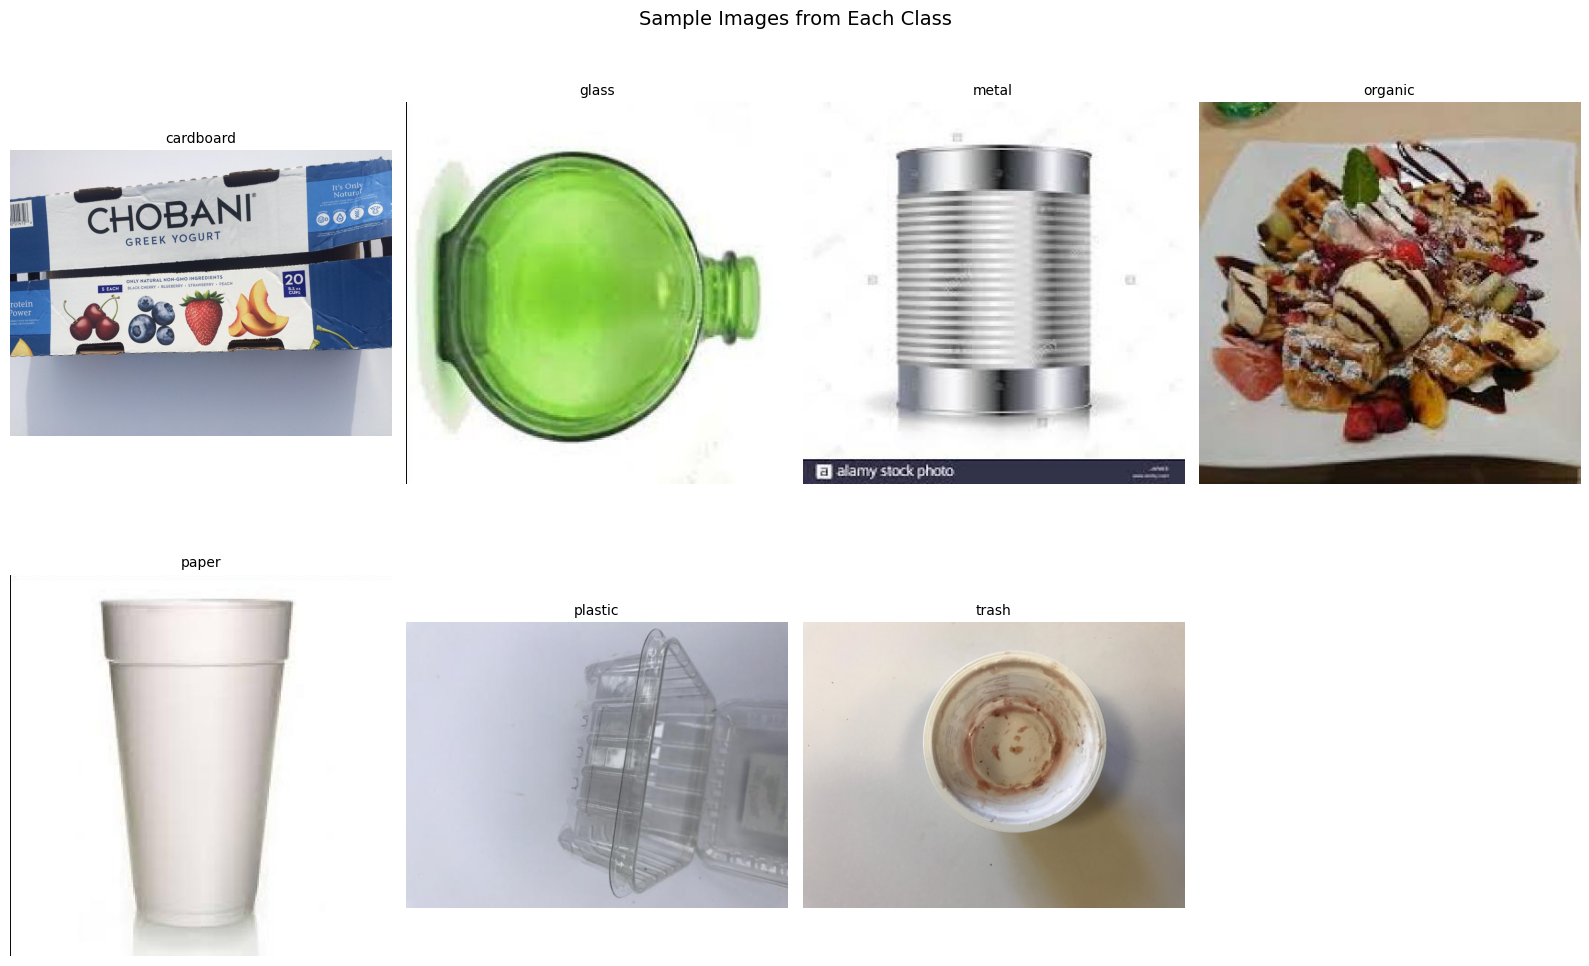

In [ ]:
# Visualize sample images from each class
class_names = sorted(os.listdir(TRAIN_DIR))
plt.figure(figsize=(16, 10))

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(TRAIN_DIR, class_name)
    image_files = os.listdir(class_path)
    sample_image = os.path.join(class_path, image_files[0])
    
    img = Image.open(sample_image)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name.replace('rubbish__', '').replace('_', ' '), fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Each Class', fontsize=14, y=1.02)
plt.show()

## 4. Data Augmentation & Generators

**Strategy**: Use aggressive augmentation to create 10,000+ unique training samples per epoch.

**Augmentation Techniques**:
- Rotation (±40°)
- Width/Height shift (20%)
- Shear transformation (20%)
- Zoom (20%)
- Horizontal flip
- Rescaling (normalization)

In [7]:
# Training data generator with aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

# Calculate steps to ensure 10,000+ samples per epoch
STEPS_PER_EPOCH = max(train_generator.samples // BATCH_SIZE, 10000 // BATCH_SIZE)

print(f"\n{'='*60}")
print("DATA GENERATOR CONFIGURATION")
print(f"{'='*60}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nSteps per epoch: {STEPS_PER_EPOCH}")
print(f"Effective training samples per epoch: {STEPS_PER_EPOCH * BATCH_SIZE}")
print(f"\n✓ Meets 10,000+ image requirement: {STEPS_PER_EPOCH * BATCH_SIZE >= 10000}")
print(f"{'='*60}")

Found 18919 images belonging to 7 classes.
Found 2362 images belonging to 7 classes.
Found 2371 images belonging to 7 classes.

DATA GENERATOR CONFIGURATION
Training samples: 18919
Validation samples: 2362
Test samples: 2371

Steps per epoch: 591
Effective training samples per epoch: 18912

✓ Meets 10,000+ image requirement: True


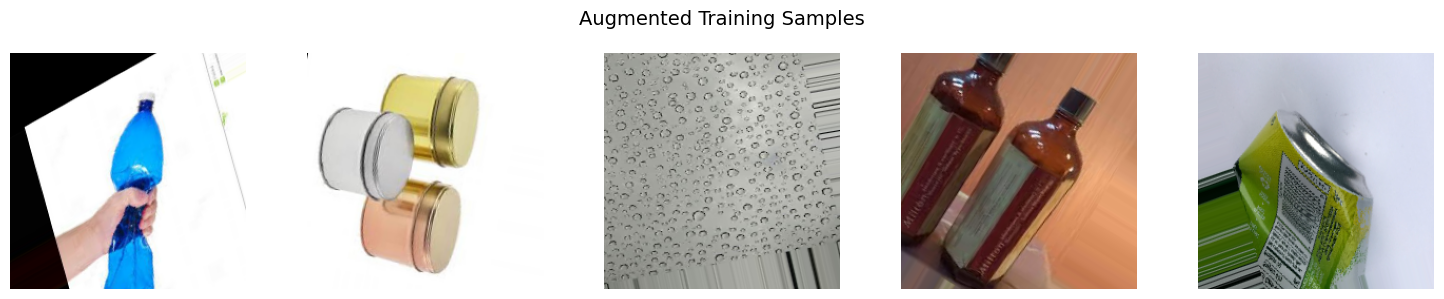

In [8]:
# Visualize augmentation effects
sample_batch, _ = next(train_generator)
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_batch[i])
    plt.axis('off')
plt.suptitle('Augmented Training Samples', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Model Architecture

**Architecture**: Sequential model combining:
1. **MobileNetV2** (pre-trained on ImageNet, frozen)
2. **Custom Conv2D + MaxPooling** (meets Dicoding requirements)
3. **GlobalAveragePooling2D** (reduces parameters)
4. **Dense layers** with Dropout for classification

This hybrid approach:
- ✓ Uses Sequential API
- ✓ Contains explicit Conv2D and MaxPooling2D layers
- ✓ Leverages transfer learning for 95%+ accuracy

In [10]:
# Base model (MobileNetV2 without top layers)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False 
model = models.Sequential([
    base_model,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='custom_conv2d'),
    layers.MaxPooling2D(pool_size=(2, 2), name='custom_maxpool'),

    layers.GlobalAveragePooling2D(),
    
    # Classification head
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
], name='RubbishClassifier')

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "RubbishClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d (Conv2D)          │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_maxpool (MaxPooling2D)   │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,551 (11.46 MB)

 Trainable params: 746,567 (2.85 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6. Custom Callback Implementation

**AccuracyThresholdCallback**: Automatically stops training when both training and validation accuracy reach 95%.

In [16]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to stop training when accuracy threshold is reached.
    
    Stops training when BOTH train_accuracy AND val_accuracy >= threshold.
    """
    def __init__(self, threshold=0.95):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        
        if train_acc >= self.threshold and val_acc >= self.threshold:
            print(f"\n{'='*60}")
            print(f"✓ TARGET ACHIEVED!")
            print(f"  Training Accuracy: {train_acc:.4f} (>= {self.threshold})")
            print(f"  Validation Accuracy: {val_acc:.4f} (>= {self.threshold})")
            print(f"  Stopping training at epoch {epoch + 1}")
            print(f"{'='*60}\n")
            self.model.stop_training = True

# Test the callback
print("✓ AccuracyThresholdCallback created successfully")
print(f"  Threshold: {ACCURACY_THRESHOLD * 100}%")

✓ AccuracyThresholdCallback created successfully
  Threshold: 95.0%


## 7. Model Training

Training with callbacks:
1. **AccuracyThresholdCallback**: Auto-stop at 95%
2. **ModelCheckpoint**: Save best model
3. **EarlyStopping**: Prevent overfitting

In [17]:
# Setup callbacks
callbacks = [
    AccuracyThresholdCallback(threshold=ACCURACY_THRESHOLD),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model
print("\nStarting training...\n")
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")


Starting training...



UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f2925823830>

## 8. Training Visualization

Visualize training progress with accuracy and loss plots.

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Target', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n{'='*60}")
print("FINAL TRAINING METRICS")
print(f"{'='*60}")
print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"\n✓ Accuracy >= 95%: {final_train_acc >= 0.95 and final_val_acc >= 0.95}")
print(f"{'='*60}")

## 9. Model Evaluation on Test Set

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*60}")
print("TEST SET EVALUATION")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"\n✓ Test Accuracy >= 95%: {test_accuracy >= 0.95}")
print(f"{'='*60}")

## 10. Model Deployment (3 Formats)

Export model in three required formats:
1. **SavedModel** (TensorFlow native format)
2. **TF-Lite** (Mobile/Edge deployment)
3. **TensorFlow.js** (Web deployment)

In [ ]:
# 1. SavedModel format
print("Saving model in SavedModel format...")
model.save('model_deployment')
print("✓ SavedModel saved to: model_deployment/")

In [ ]:
# 2. TF-Lite format
print("\nConverting to TF-Lite format...")
converter = tf.lite.TFLiteConverter.from_saved_model('model_deployment')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize('model.tflite') / (1024 * 1024)
print(f"✓ TF-Lite model saved to: model.tflite ({tflite_size:.2f} MB)")

In [ ]:
# 3. TensorFlow.js format
print("\nConverting to TensorFlow.js format...")
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras_saved_model --output_format=tfjs_graph_model model_deployment tfjs_model
print("✓ TensorFlow.js model saved to: tfjs_model/")

In [ ]:
# Verify all formats exist
print(f"\n{'='*60}")
print("DEPLOYMENT VERIFICATION")
print(f"{'='*60}")
print(f"✓ SavedModel: {os.path.exists('model_deployment')}")
print(f"✓ TF-Lite: {os.path.exists('model.tflite')}")
print(f"✓ TensorFlow.js: {os.path.exists('tfjs_model')}")
print(f"\n✓ All 3 deployment formats created successfully!")
print(f"{'='*60}")

## 11. Inference Demonstration

Demonstrate model inference on new images.

In [ ]:
# Get class names
class_names = sorted(train_generator.class_indices.keys())
class_names_clean = [name.replace('rubbish__', '').replace('_', ' ') for name in class_names]

print("Class names:")
for idx, name in enumerate(class_names_clean):
    print(f"  {idx}: {name}")

In [ ]:
def predict_image(image_path, model, class_names, top_k=3):
    """
    Predict class for a single image and display results.
    
    Args:
        image_path: Path to image file
        model: Trained Keras model
        class_names: List of class names
        top_k: Number of top predictions to show
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize(IMG_SIZE)
    img_array = np.array(img_resized) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_batch, verbose=0)[0]
    
    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    # Display results
    plt.figure(figsize=(12, 4))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    predicted_class = class_names[top_indices[0]]
    confidence = predictions[top_indices[0]] * 100
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", 
              fontsize=12, fontweight='bold')
    
    # Show top-k predictions
    plt.subplot(1, 2, 2)
    top_classes = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] * 100 for i in top_indices]
    
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(top_k)]
    bars = plt.barh(range(top_k), top_probs, color=colors)
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence (%)', fontsize=10)
    plt.title(f'Top-{top_k} Predictions', fontsize=12, fontweight='bold')
    plt.xlim([0, 100])
    
    # Add percentage labels
    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        plt.text(prob + 2, i, f'{prob:.2f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*60}")
    print("PREDICTION RESULTS")
    print(f"{'='*60}")
    for i, (cls, prob) in enumerate(zip(top_classes, top_probs), 1):
        print(f"{i}. {cls}: {prob:.2f}%")
    print(f"{'='*60}\n")

print("✓ Inference function created")

In [ ]:
# Test inference on random test images
print("Testing inference on sample images from test set...\n")

# Get random test images
test_classes = os.listdir(TEST_DIR)
sample_class = np.random.choice(test_classes)
sample_class_dir = os.path.join(TEST_DIR, sample_class)
sample_images = os.listdir(sample_class_dir)
sample_image = np.random.choice(sample_images)
sample_path = os.path.join(sample_class_dir, sample_image)

print(f"True class: {sample_class.replace('rubbish__', '').replace('_', ' ')}\n")
predict_image(sample_path, model, class_names_clean, top_k=3)

In [ ]:
# Optional: Upload and predict custom image
# Uncomment the following code if running in Google Colab

# from google.colab import files
# print("Upload an image for prediction:")
# uploaded = files.upload()
# 
# for filename in uploaded.keys():
#     print(f"\nPredicting for: {filename}")
#     predict_image(filename, model, class_names_clean, top_k=3)